# 2A. Cropping and Resizing Dog Images from XML Annotations
### Using XML Processing and PIL
This code snippet demonstrates how to extract bounding box information from XML annotation files, crop images of dogs from a specified directory using these bounding boxes, and resize each cropped image to 128×128 pixels. The cropped images are saved in a designated output directory.


In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, feature
from sklearn.metrics import pairwise
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import json
import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
import xml.etree.ElementTree as ET 
import glob
from PIL import Image 
from pathlib import Path
from PIL import Image, ImageEnhance


In [3]:
# Define directories
dog_images_dir = glob.glob('/Users/thota/Documents/Datamining/Datasets/MyDogs/*/*')
annotations_dir = glob.glob('/Users/thota/Documents/Datamining/Datasets/MyAnnos/*/*')
cropped_images_dir = '/Users/thota/Documents/Datamining/Datasets/Cropped/'

# Function to parse bounding boxes from annotation files
def get_bounding_boxes(annot):
    tree = ET.parse(annot)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox

# Function to get image path based on the annotation file
def get_image(annot):
    img_path = '/Users/thota/Documents/Datamining/Datasets/MyDogs/'
    path_parts = annot.split('\\') 
    folder = path_parts[-2]
    filename = f"{path_parts[-1].replace('.xml', '')}.jpg"
    img_filename = os.path.join(img_path, folder, filename)
    return img_filename

# Process the images
print(len(dog_images_dir))
for i in range(len(dog_images_dir)):
    bbox = get_bounding_boxes(annotations_dir[i])
    dog = get_image(annotations_dir[i])
    im = Image.open(dog)
    print(im)
    
    # Crop and resize the bounding boxes
    for j in range(len(bbox)):
        im2 = im.crop(bbox[j])
        im2 = im2.resize((128, 128), Image.Resampling.LANCZOS)  
        new_path = dog.replace('MyDogs', 'Cropped')
        new_path = new_path.replace('.jpg', '-' + str(j) + '.jpg')

        # Create directories if they don't exist
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)

        # Save the cropped image
        im2.save(new_path)

622
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x332 at 0x25911C5C050>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500 at 0x25914F63C50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500 at 0x25914F63FD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x293 at 0x25914F63950>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x300 at 0x25914F62E10>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x332 at 0x25914F63390>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x332 at 0x25914F6CFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x335 at 0x25914F6D290>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375 at 0x25914F6D3D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x25914F6D550>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x465 at 0x25914F6D2D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x300 at 0x25914F6D850>
<PIL.JpegImagePlugin.Jpe

#  2B. Feature Extraction: Edge Histogram and Similarity Measurements
This section describes how to extract features from cropped dog images and measure their similarity.

1. **Select Images**: Choose one image from each class.
2. **Convert to Grayscale**: Change the color images to grayscale.
3. **Calculate Edge Angles**: Use Sobel filters to find the edge direction for each pixel:
4. **Compare Histograms**: Measure similarity between the first two images using Euclidean, Manhattan, and Cosine distances.


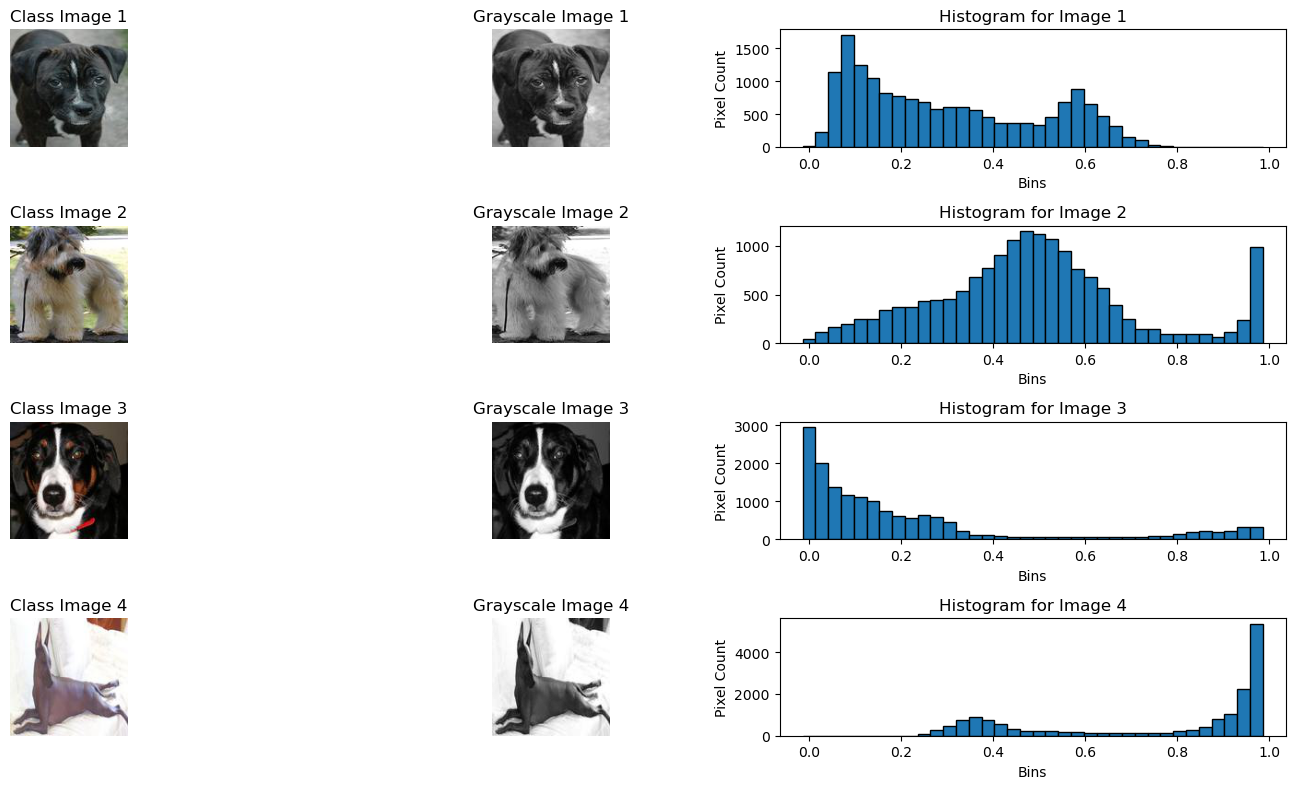

Euclidean Distance: 0.18533730969634396
Manhattan Distance: 0.777587890625
Cosine Distance: 0.3626026514519938


In [4]:
def process_images_and_histograms(cropped_images_dir):
    # Step 1: Get all directories inside the cropped images directory
    directory_paths = glob.glob(os.path.join(cropped_images_dir, '*'))
    
    # Step 2: Choose one image from each directory
    selected_images = []
    class_names = [] 

    for directory in directory_paths:
        # Get the first image in each directory
        image_paths = glob.glob(os.path.join(directory, '*'))
        if image_paths:  
            selected_images.append(image_paths[0])  
            class_name = os.path.basename(directory)  
            class_names.append(class_name)

    # Function to process images
    def process_image(image_path):
        # Load the image
        image = io.imread(image_path)
        
        # Convert to grayscale
        gray_image = color.rgb2gray(image)
        
        # Calculate angles using Sobel filters
        angle_sobel = np.mod(np.arctan2(filters.sobel_v(gray_image), filters.sobel_h(gray_image)), np.pi)
        
        # Obtain histogram with 36 bins
        hist, bin_edges = np.histogram(gray_image, bins=36, range=(0, 1))
        
        return image, gray_image, hist, bin_edges, angle_sobel

    # Step 3: Process selected images
    results = [process_image(img_path) for img_path in selected_images]
    original_images, gray_images, histograms, bin_edges_list, angles = zip(*results)

    # Step 4: Plot original images, grayscale images, and their corresponding histograms
    fig, axs = plt.subplots(len(gray_images), 3, figsize=(15, 8))
    for i in range(len(gray_images)):
        # Plot original image
        axs[i, 0].imshow(original_images[i])
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f'Class Image {i + 1}')
        
        # Plot grayscale image
        axs[i, 1].imshow(gray_images[i], cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title(f'Grayscale Image {i + 1}')
        
        # Plot histogram
        axs[i, 2].bar(bin_edges_list[i][:-1], histograms[i], width=np.diff(bin_edges_list[i]), edgecolor='black')
        axs[i, 2].set_title(f'Histogram for Image {i + 1}')
        axs[i, 2].set_xlabel("Bins")
        axs[i, 2].set_ylabel("Pixel Count")

    plt.tight_layout()
    plt.show()

    # Step 5: Histogram comparison between the first two images
    if len(histograms) >= 2:  
        hist1 = histograms[0]
        hist2 = histograms[1]

        # Normalize histograms
        hist1_normalized = hist1 / np.sum(hist1)
        hist2_normalized = hist2 / np.sum(hist2)

        # Calculate distances
        euclidean_distance = np.linalg.norm(hist1_normalized - hist2_normalized)
        manhattan_distance = np.sum(np.abs(hist1_normalized - hist2_normalized))
        cosine_distance = pairwise.cosine_distances([hist1_normalized], [hist2_normalized])[0][0]

        print(f'Euclidean Distance: {euclidean_distance}')
        print(f'Manhattan Distance: {manhattan_distance}')
        print(f'Cosine Distance: {cosine_distance}')
    else:
        print("Not enough images to compare histograms.")
    
    return histograms, selected_images  

cropped_images_dir = '/Users/thota/Documents/Datamining/Datasets/Cropped'
histograms, selected_images = process_images_and_histograms(cropped_images_dir)

# 2C. Histogram of Oriented Gradient (HOG) Feature Descriptor

In this section, we computed and visualized the HOG descriptors for a selected image.

### Steps:

1. **Select an Image**: Choose one image from your dataset.

2. **Compute HOG Descriptors**: 
   - Use a function to load the image and convert it to grayscale.
   - Compute the HOG features and generate the HOG image.
   - Visualize both the original grayscale image and the HOG descriptor side by side.

3. **Visualization**: 
   The original image will be displayed alongside its HOG descriptor, allowing for a visual comparison of the features captured by the HOG method.

For more information about HOG, refer to the [Wikipedia page on HOG](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) and the [scikit-image documentation](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html#sphx-glr-auto-examples-features-detection-plot-hog-py).


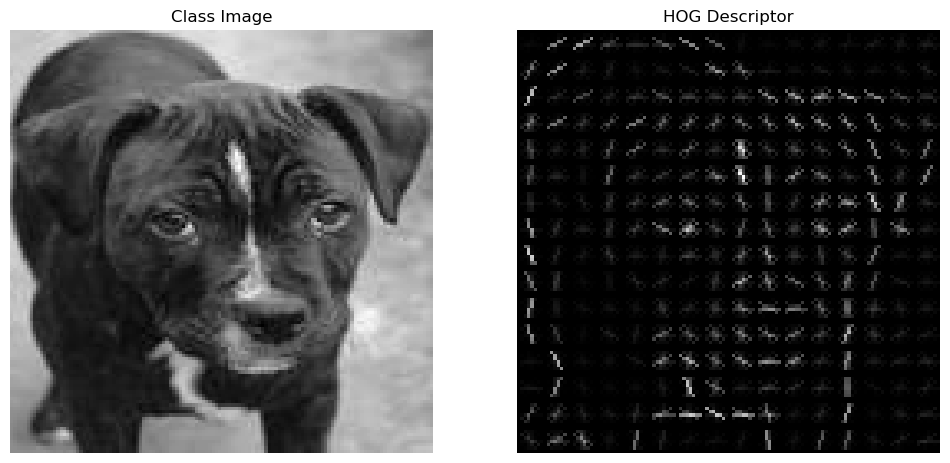

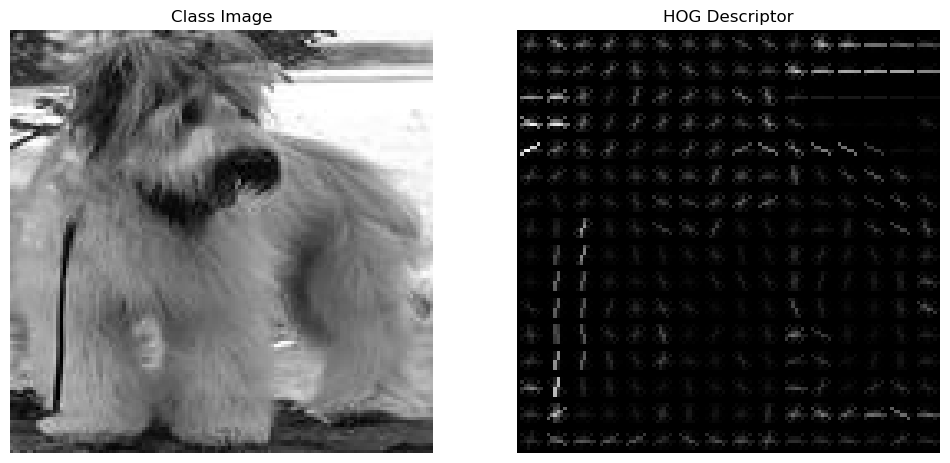

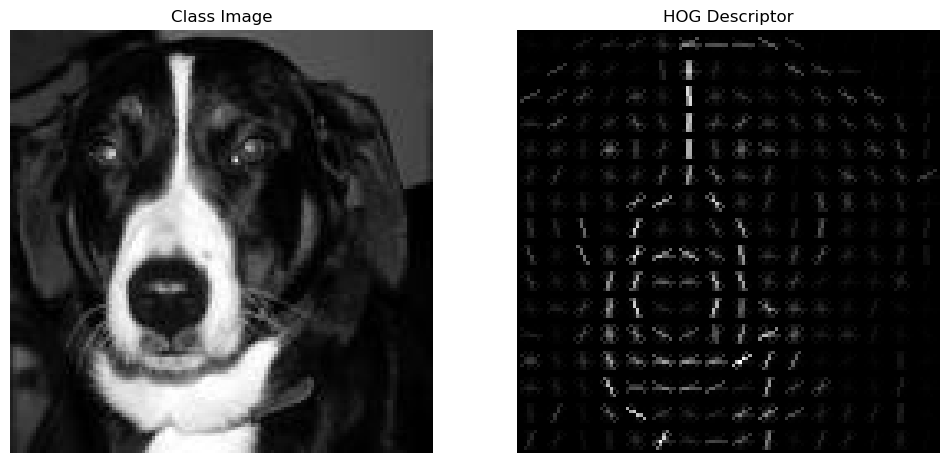

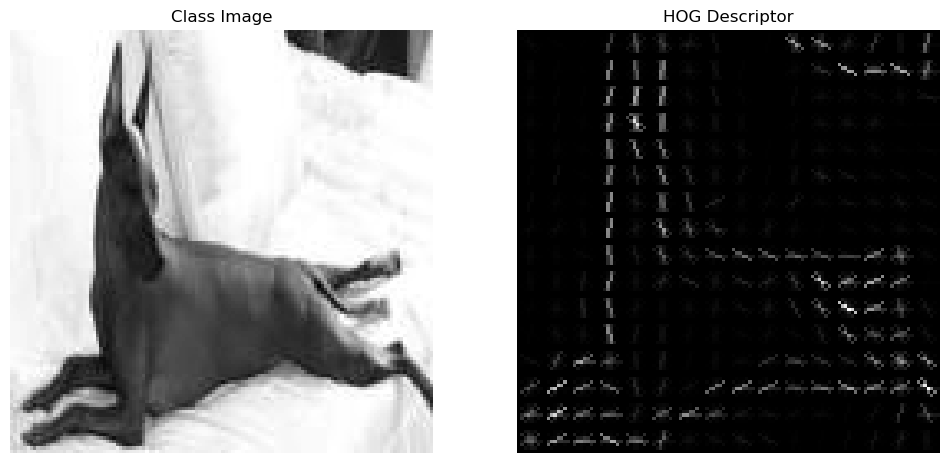

In [6]:
def compute_and_visualize_hog(image_path):
    # Load the image
    image = io.imread(image_path)
    
    # Convert to grayscale
    gray_image = color.rgb2gray(image)

    # Compute HOG features and HOG image
    hog_features, hog_image = feature.hog(gray_image, visualize=True, block_norm='L2-Hys')

    # Plot original image and HOG image
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(gray_image, cmap='gray')
    axs[0].set_title('Class Image')
    axs[0].axis('off')

    axs[1].imshow(hog_image, cmap='gray')
    axs[1].set_title('HOG Descriptor')
    axs[1].axis('off')

    plt.show()


for image_path in selected_images:
    compute_and_visualize_hog(image_path)

# 2D. Dimensionality Reduction using Principal Component Analysis (PCA)

In this section, we performed dimensionality reduction on edge histograms obtained from images of four different classes using Principal Component Analysis (PCA).

### Steps:

1. **Select Images**: Use images from all four classes in your dataset.

2. **Convert to Edge Histograms**: 
   - Convert all images from the four classes into edge histograms, which capture the distribution of edges in the images.

3. **Perform PCA**:
   - Apply PCA to the set of histograms to reduce their dimensionality from 36 dimensions to 2 dimensions. 
   - Note that during this step, class labels will not be used.

4. **Plot Results**:
   - Visualize the reduced 2D points on a scatter plot.
   - Use different colors to represent the different classes, allowing for a visual assessment of class separability in the reduced feature space.

For more details on PCA, you can refer to the [scikit-learn PCA documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and a code example using the Iris dataset can be found [here](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html).


C:\Users\thota\AppData\Local\Temp\ipykernel_5220\3092872568.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))


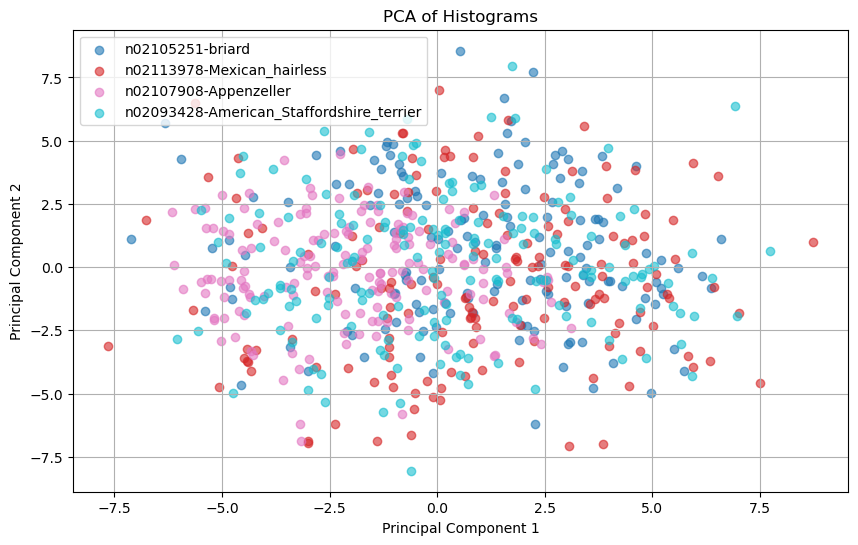

In [7]:
def process_images_and_histograms(cropped_images_dir):
    """Process images in the specified directory and compute histograms."""
    # Step 1: Get all directories inside the cropped images directory
    directory_paths = glob.glob(os.path.join(cropped_images_dir, '*'))
    
    histograms = []  
    class_names = [] 

    # Step 2: Iterate through directories and process images
    for directory in directory_paths:
        class_name = os.path.basename(directory)
        image_paths = glob.glob(os.path.join(directory, '*'))  
        
        for image_path in image_paths:
            # Load the image
            image = io.imread(image_path)
            
            # Convert to grayscale
            gray_image = color.rgb2gray(image)
            
            # Obtain histogram with 36 bins
            hist, _ = np.histogram(gray_image, bins=36, range=(0, 1))
            
            histograms.append(hist)  # Store the histogram
            class_names.append(class_name)  

    return np.array(histograms), class_names

def perform_pca(histograms, n_components=2):
    """Perform PCA on histograms and return the principal components."""
    # Standardize the histograms
    scaler = StandardScaler()
    histograms_scaled = scaler.fit_transform(histograms)

    # Perform PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(histograms_scaled)
    
    return principal_components

def plot_pca(principal_components, class_names):
    """Plot PCA results with labels."""
    unique_classes = list(set(class_names))
    colors = plt.cm.get_cmap('tab10', len(unique_classes))

    plt.figure(figsize=(10, 6))
    for i, class_name in enumerate(unique_classes):
        class_indices = [j for j, name in enumerate(class_names) if name == class_name]
        plt.scatter(principal_components[class_indices, 0], principal_components[class_indices, 1],
                    label=class_name, color=colors(i), alpha=0.6)

    plt.title('PCA of Histograms')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid()
    plt.show()

# Main Execution
# Specify the directory containing cropped images
cropped_images_dir = '/Users/thota/Documents/Datamining/Datasets/Cropped'  

# Step 1: Process images and compute histograms
histograms, class_names = process_images_and_histograms(cropped_images_dir)

# Step 2: Perform PCA on the histograms
principal_components = perform_pca(histograms)

# Step 3: Plot the PCA results
plot_pca(principal_components, class_names)


## 4 Feature Extraction from Tweets

We will use `CountVectorizer` and `TfidfVectorizer` from Scikit-learn to analyze the tweet dataset.

### What We Will Do
1. **CountVectorizer**: Count how many times each word appears in the tweets.
2. **TfidfVectorizer**: Calculate the importance of each word in the tweets.

### Results
We will check the size of the two feature sets we created.


In [11]:
import json
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def load_and_extract(file_path):
    """Load tweet data and extract texts."""
    with open(file_path, 'r') as file:
        return [json.loads(line.strip())['Tweet'] for line in file]

def compute_vectorizations(texts):
    """Compute Count and TF-IDF Vectorizations."""
    count_vectorizer = CountVectorizer().fit_transform(texts)
    tfidf_vectorizer = TfidfVectorizer().fit_transform(texts)
    return count_vectorizer, tfidf_vectorizer

def print_dimensionalities(X_counts, X_tfidf):
    """Print dimensionalities of vectorized representations."""
    print(f'Dimensionality of Count Vectorizer: {X_counts.shape[1]}')
    print(f'Dimensionality of TF-IDF Vectorizer: {X_tfidf.shape[1]}')

file_path = r'C:\Users\thota\Documents\Datamining\Datasets\student_29\train.json'
texts = load_and_extract(file_path)
X_counts, X_tfidf = compute_vectorizations(texts)
print_dimensionalities(X_counts, X_tfidf)


Dimensionality of Count Vectorizer: 9613
Dimensionality of TF-IDF Vectorizer: 9613


## 5 Dimensionality Reduction and Visualization of Tweet Classes

### Selected Classes
For this analysis, we will pick the following four classes that are expected to be separable:
1. Anger
2. Joy
3. Fear
4. Trust

### Dimensionality Reduction
We will perform dimensionality reduction on both the token count features and TF-IDF features, reducing them to 2 dimensions.

### Visualization
We will create two separate plots:
1. **Token Count Features**: Plot the 2D points using four different colors for the selected classes.
2. **TF-IDF Features**: Plot the 2D points using four different colors for the selected classes.

### Observations
After plotting, we will analyze how many classes are visually separable (i.e., non-overlapping) in both plots.


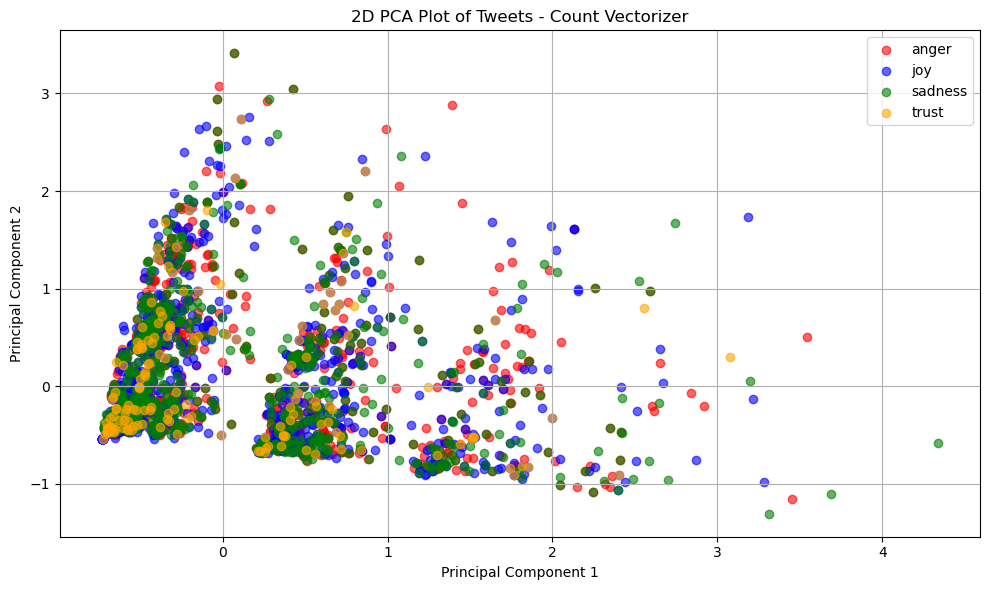

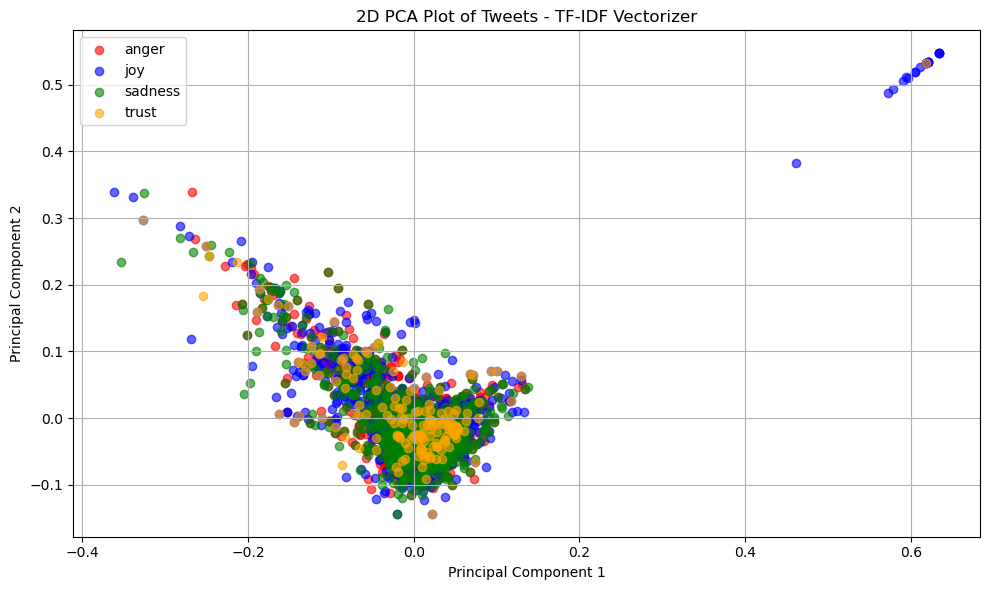

In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def extract_labels(tweets, selected_classes):
    """Extract binary labels for selected classes."""
    return np.array([[int(tweet[class_name]) for class_name in selected_classes] for tweet in tweets if 'Tweet' in tweet])

def perform_pca_and_plot(X, labels, classes, feature_type='Count'):
    """Perform PCA and plot the results."""
    X_reduced = PCA(n_components=2).fit_transform(X)
    plt.figure(figsize=(10, 6))
    colors = ['red', 'blue', 'green', 'orange']
    
    for i, class_name in enumerate(classes):
        plt.scatter(X_reduced[labels[:, i] == 1, 0], X_reduced[labels[:, i] == 1, 1], 
                    label=class_name, color=colors[i], alpha=0.6)

    plt.title(f'2D PCA Plot of Tweets - {feature_type} Vectorizer')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Load tweet texts
file_path = r'C:\Users\thota\Documents\Datamining\student_29\train.json'
texts = load_and_extract(file_path)

# Define classes to analyze
selected_classes = ['anger', 'joy', 'sadness', 'trust']

# Extract the labels from the original data
with open(file_path, 'r') as file:
    tweets = [json.loads(line.strip()) for line in file]
labels = extract_labels(tweets, selected_classes)

# Vectorization
X_counts = CountVectorizer().fit_transform(texts).toarray()
X_tfidf = TfidfVectorizer().fit_transform(texts).toarray()

# Perform PCA and plot for both vectorizers
for X, feature_type in zip([X_counts, X_tfidf], ['Count', 'TF-IDF']):
    perform_pca_and_plot(X, labels, selected_classes, feature_type)


The classes(anger, joy, sadness, and trust) are not separable in either the Count Vectorizer or TF-IDF Vectorizer plots, as there is significant
overlap between the points.